In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import pandas as pd
from matplotlib.lines import Line2D
import scipy.stats as stats

In [2]:
print(os.listdir(os.path.join(os.getcwd(),"ExperimentLogs")))

['A', 'B', 'C_Prelim', 'D', 'debug', 'E', 'Finalissima', 'Final_h', 'info.txt']


In [3]:
last_exp = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Finalissima"

In [4]:
def load_all_pickles(directory:str, model: str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

## Store the results of all Model/Scenario Combinations 

In [5]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect")
#XG_perfect = load_all_pickles(last_exp, "XGBOOST", "perfect")
mlp_perfect = load_all_pickles(last_exp, "MLP", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant")
#XG_com = load_all_pickles(last_exp, "XGBOOST", "community_relevant")
mlp_com = load_all_pickles(last_exp, "MLP", "community_relevant")

gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic")
#XG_com_h = load_all_pickles(last_exp, "XGBOOST", "community_relevant_heterophilic")
mlp_com_h = load_all_pickles(last_exp, "MLP", "community_relevant_heterophilic")

# gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_random")
# gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_random")
# sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_random")
# XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_random")

#gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_sparse")
#gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_sparse")
#sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_sparse")
#XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_sparse")
#XG_com_r = load_all_pickles(last_exp, "MLP", "community_relevant_sparse")

gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant")
#XG_feat = load_all_pickles(last_exp, "XGBOOST", "cluster_relevant")
mlp_feat = load_all_pickles(last_exp, "MLP", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant")
#XG_feat_p = load_all_pickles(last_exp, "XGBOOST", "non_seperated_cluster_relevant")
mlp_feat_p = load_all_pickles(last_exp, "MLP", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise")
#XG_noise = load_all_pickles(last_exp, "XGBOOST", "noise")
mlp_noise = load_all_pickles(last_exp, "MLP", "noise")


In [6]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h,
                     gcn_feat, gcn_feat_p, gcn_noise],  
                    [gat_perfect, gat_com, gat_com_h, 
                     gat_feat, gat_feat_p, gat_noise],  
                    [sage_perfect, sage_com, sage_com_h,
                     sage_feat, sage_feat_p, sage_noise],  
                    [mlp_perfect, mlp_com, mlp_com_h,
                     mlp_feat, mlp_feat_p, mlp_noise]])

n_scenarios = package.shape[1]
print(n_scenarios)

colors = ["darkgreen", "darkblue", "grey", "purple", "yellow", "darkred"]
#colors = ["forestgreen", "royalblue", "dodgerblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


6


# Plot 

In [7]:
def plot_with_confidence_interval(target, color, add_final_epoch, key="loss_track", empirical_CI=True, ax=None, percentiles=5):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param key: Key to extract values from target.
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :return: None
    """
    ys = np.array([lp[key] for lp in target])  # loss-values @ epoch
    final_epoch = np.mean([lp["final_epoch"] for lp in target])

    mean_ys = np.mean(ys, axis=0)
    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))

    ax.plot(x, mean_ys, color=color, linewidth=1.5)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.1) if empirical_CI==True else None
    if add_final_epoch == "loss_track":
        ax.axvline(x=final_epoch, color=color, linestyle='--')
    
    return final_epoch

def plot_cumulated_time(target, color, empirical_CI=True, percentiles=5):
    ys = np.array([lp["epoch_times"] for lp in target])  # loss-values @ epoch
    #mean_ys = np.cumsum(np.mean(ys, axis=0))
    mean_ys = np.mean(ys, axis=0)

    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, percentiles, axis=0)
        ci_upper = np.percentile(ys, (100-percentiles), axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))
    final_avg = np.mean(mean_ys)
    ax.plot(x, mean_ys, color=color, linewidth=1.5)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.1) if empirical_CI==True else None
    ax.axhline(y=final_avg, color=color, linestyle='--', linewidth=.5)
    
    return final_avg


### Loss/Validation Accuracy - Curves

In [ ]:
l_o_a = "loss_track"  
#l_o_a = "val_acc_track"
#l_o_a = "time"


arch = ["GCN", "GAT", "SAGE", "MLP"]
colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

early_stops = np.zeros((5, n_scenarios + 1))
labels = np.arange(n_scenarios) + 1

for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        if l_o_a in ["val_acc_track","loss_track"]:
            early_stops[i, j] = plot_with_confidence_interval(target, color, key=l_o_a,
                                                              empirical_CI=False, ax=ax, percentiles=5,
                                                              add_final_epoch=l_o_a)
        else:
            early_stops[i, j] = plot_cumulated_time(target, color, empirical_CI=False)
        
        ax.axhline(y=0.2, color='grey', linestyle='--') if l_o_a == "val_acc_track" else None
        ax.plot([], [], color=color, label=label)  

    ax.set_xlabel('Epoch')
    if l_o_a == "loss_track":
        ax.set_ylabel('Average Loss')
    elif l_o_a == "val_acc_track":
        ax.set_ylabel('Average Validation Accuracy')
    else:
        ax.set_ylabel('Average Validation Accuracy')
        
        
    ax.set_ylim(0, 1) if l_o_a == "val_acc_track" else None#ax.set_ylim(0, 4000) 
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]  # Farben unterscheiden 
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

early_stops[-1,0:-1] = np.mean(early_stops[:-1, :-1], axis=0)  # row-wise average
early_stops[0:-1,-1] = np.mean(early_stops[:-1,:-1], axis=1)  # col-wise average

plt.tight_layout()
plt.show()
np.round(early_stops, 2)

#  GCN könnte mehr epochs vertragen !!
# Erwartungswert von random guess (Wahrscheinlichkeit) 600/3000
# Zeit pro Epoche -> Zeitvergleich 


### Test accs 

In [51]:
mus = np.zeros((4, n_scenarios))  # models (i) x scenarios (j)
#sigs = np.zeros((4, n_scenarios))  
sigs = np.empty((4, n_scenarios), dtype="U64")  
upper_lower = lambda x, p : str((round(np.percentile(x, p, axis=0), 3), round(np.percentile(x, 100-p, axis=0), 3)))
normal = np.zeros((4, n_scenarios))

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6, 7]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        #sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)
        sigs[i, j] = upper_lower(accs, 5)
        _, normal[i, j] = stats.shapiro(accs)


result = np.array([[f'{a} {b}' for a, b in zip(row_A, row_B)]
                   for row_A, row_B in zip(mus, sigs)])        

result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","MLP"],
                      columns=["Perfect", "com", "com_h",
                               #"com_sparse",
                               "feat", "feat_p", "noise"])
result
# normal < .05

,Perfect,com,com_h,feat,feat_p,noise
GCN,"0.86 (0.831, 0.886)","0.708 (0.665, 0.749)","0.517 (0.238, 0.685)","0.418 (0.195, 0.578)","0.397 (0.226, 0.474)","0.286 (0.198, 0.362)"
GAT,"0.931 (0.91, 0.951)","0.75 (0.7, 0.797)","0.703 (0.561, 0.79)","0.712 (0.62, 0.785)","0.658 (0.591, 0.709)","0.391 (0.317, 0.453)"
SAGE,"0.938 (0.914, 0.956)","0.748 (0.7, 0.79)","0.729 (0.683, 0.795)","0.77 (0.716, 0.814)","0.708 (0.659, 0.753)","0.407 (0.351, 0.458)"
MLP,"0.942 (0.922, 0.963)","0.649 (0.553, 0.704)","0.632 (0.568, 0.705)","0.768 (0.71, 0.814)","0.635 (0.594, 0.682)","0.367 (0.319, 0.438)"


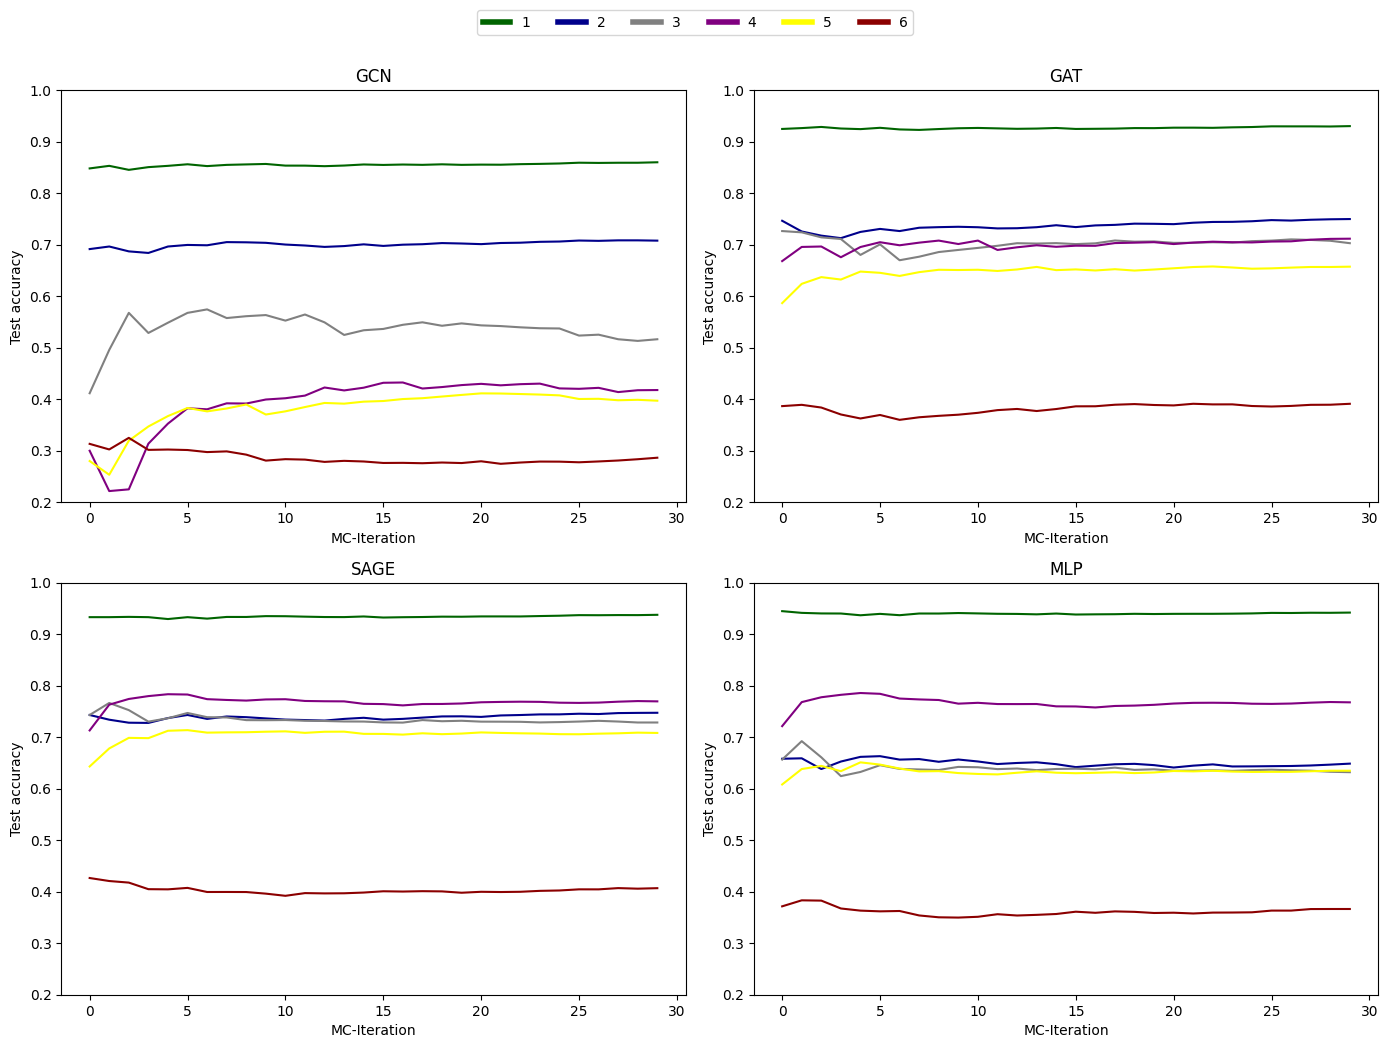

array([[29., 29., nan, nan, nan, 29.],
       [29., 29., 29., 29., 29., 29.],
       [29., 29., 29., nan, 29., 29.],
       [29., 29., 29., 29., 29., 29.]])

In [9]:
def MC_check_convergence(x, eps):
    for i in range(len(x) - 1):
        if abs(x[i+1] - x[i]) > eps:
            return None
    return len(x) - 1

def MCR_plot(target, color, ax=None):
        ys = [lp["test_accuracy"] for lp in target] 
        r_avg = np.cumsum(ys) / np.arange(1, len(ys) + 1)
        x = np.arange(len(ys))
        ax.plot(x, r_avg, color=color)
        
        return MC_check_convergence(r_avg, 0.05)
        
arch = ["GCN", "GAT", "SAGE", "MLP"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

labels = np.arange(n_scenarios) + 1
# colors = ["forestgreen", "royalblue", "mediumslateblue", "darkorange", "goldenrod", "firebrick"]

converged_at = np.zeros((4, n_scenarios))

for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        converged_at[i, j] = MCR_plot(target, color, ax=ax)
        ax.plot([], [], color=color, label=label) 

    ax.set_xlabel('MC-Iteration')
    ax.set_ylim(.2, 1)
    ax.set_ylabel('Test accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()
converged_at


# Graph Characteristics 

In [10]:
def load_all_pickles_char(directory:str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

In [11]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
#community_relevant_r = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_sparse")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

package2 = np.array(([perfect, community_relevant, community_relevant_h,
            #community_relevant_r,
            cluster_relevant, cluster_relevant_p, noise]))

n_scenarios = package2.shape[0]
n_scenarios

6

In [15]:
root = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\Final_h"
 
gcn_vs = load_all_pickles(root, "GCN", "very_strong")
gat_vs = load_all_pickles(root, "GAT", "very_strong")
sage_vs = load_all_pickles(root, "SAGE", "very_strong")
mlp_vs= load_all_pickles(root, "MLP", "very_strong")

gcn_s = load_all_pickles(root, "GCN", "strong")
gat_s = load_all_pickles(root, "GAT", "strong")
sage_s = load_all_pickles(root, "SAGE", "strong")
mlp_s= load_all_pickles(root, "MLP", "strong")

gcn_m = load_all_pickles(root, "GCN", "mid")
gat_m = load_all_pickles(root, "GAT", "mid")
sage_m = load_all_pickles(root, "SAGE", "mid")
mlp_m = load_all_pickles(root, "MLP", "mid")

gcn_w = load_all_pickles(root, "GCN", "weak")
gat_w = load_all_pickles(root, "GAT", "weak")
sage_w = load_all_pickles(root, "SAGE", "weak")
mlp_w = load_all_pickles(root, "MLP", "weak")

gcn_vw = load_all_pickles(root, "GCN", "very_weak")
gat_vw = load_all_pickles(root, "GAT", "very_weak")
sage_vw = load_all_pickles(root, "SAGE", "very_weak")
mlp_vw = load_all_pickles(root, "MLP", "very_weak")

package3 = np.array([[gcn_vs, gcn_s, gcn_m, 
                     gcn_w, gcn_vw],  
                    [gat_vs, gat_s, gat_m, 
                     gat_w, gat_vw],  
                    [sage_vs, sage_s, sage_m, 
                     sage_w, sage_vw],  
                    [mlp_vs, mlp_s, mlp_m, 
                     mlp_w, mlp_vw]])

very_strong = load_all_pickles_char(directory=root,graphtype="very_strong")
strong = load_all_pickles_char(directory=root,graphtype="strong")
mid = load_all_pickles_char(directory=root,graphtype="mid") 
weak = load_all_pickles_char(directory=root,graphtype="weak")
very_weak = load_all_pickles_char(directory=root,graphtype="very_weak")

package4 = np.array(([very_strong, strong, mid,
            weak, very_weak]))

n_scenarios = package3.shape[1]
print(n_scenarios)

5


In [38]:
def cor_table(pckg, n_scenarios, col_names):
    
    mus = np.zeros((2, n_scenarios))  
    sigs = np.empty((2, n_scenarios), dtype="U64")  
    upper_lower = lambda x, p : str((round(np.percentile(x, p, axis=0), 2), round(np.percentile(x, 100-p, axis=0), 2)))
    
    for k, m in enumerate(["h_hat", "wilks_lambda"]):
        for i, s in enumerate(pckg): # package4 or 2
            y = np.array([acc[m][0] for j, acc in enumerate(s)]) if m == "wilks_lambda" \
                else np.array([acc[m] for j, acc in enumerate(s)])
    
            accuracy = np.mean(y) if m == "h_hat" else np.mean(1-y)
            # sd_accuracy = np.var(y)
            # sigs[k, i] += np.round(np.sqrt(sd_accuracy), 3)
            
            mus[k, i] += np.round(accuracy, 3)
            sigs[k, i] = str(upper_lower(y, 5)) if m == "h_hat" else str(upper_lower(1-y, 5))
        
        
        result = np.array([[f'{a} {b}' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
        result = pd.DataFrame(result,
                              index=["h", "L"],
                              columns=col_names)
    
    return result

cor_table(package2, 6 ,["Perfect", "com", "com_h", "feat", "feat_p", "noise"])
#cor_table(package4, 5 ,["very_strong", "strong", "mid", "weak", "very_weak"])

# 1 - L: für bessere Interpretierbarkeit 
# Standardabweichungen vielleicht durch quantile ersetzen 
# 0.037 (0.044) Problematisch 

,Perfect,com,com_h,feat,feat_p,noise
h,"0.592 (0.57, 0.62)","0.365 (0.32, 0.42)","0.0 (0.0, 0.0)","0.001 (0.0, 0.0)","0.001 (0.0, 0.0)","0.012 (0.01, 0.01)"
L,"0.797 (0.73, 0.84)","0.322 (0.24, 0.39)","0.316 (0.2, 0.41)","0.504 (0.42, 0.6)","0.323 (0.22, 0.46)","0.085 (0.06, 0.11)"


### Class balances 

In [14]:
res = np.zeros((5,6))  # 5 classes
for i, scen in enumerate(package2):
    res[:,i] = np.round(np.mean([r["class_balance"] for r in scen], axis=0),2)

row_avgs = res.mean(axis=1)  # Average across rows
col_avgs = res.mean(axis=0)  # Average across columns

res_with_row_avgs = np.column_stack((res, row_avgs))
res_with_avgs = np.vstack((res_with_row_avgs, np.append(col_avgs, np.nan)))  # Use NaN for the last cell

res_with_avgs

array([[594.33      , 587.47      , 582.2       , 611.37      ,
        611.37      , 609.8       , 599.42333333],
       [604.8       , 610.47      , 606.9       , 589.77      ,
        589.77      , 603.8       , 600.91833333],
       [594.97      , 586.87      , 601.97      , 591.87      ,
        591.87      , 596.93      , 594.08      ],
       [596.9       , 590.9       , 604.77      , 613.83      ,
        613.83      , 593.83      , 602.34333333],
       [609.        , 624.3       , 604.17      , 593.17      ,
        593.17      , 595.63      , 603.24      ],
       [600.        , 600.002     , 600.002     , 600.002     ,
        600.002     , 599.998     ,          nan]])

In [25]:
def create_scatter_data(scens, caracs, n_scenarios):
    """
    :param scens: either "package" or "package3"
    :param caracs: either "package2" or "package4"
    :param n_scenarios: 5 or 6 
    :return: 
    """
    Y = np.zeros((4,n_scenarios,30))
    rs = Y.shape[1] * Y.shape[2]
    
    for i, model in enumerate(scens): #[[GCN,...], [GAT,...],...]
        for j, scen in enumerate(model): # [1, 2, 3, 4, 5, ...]
            accs = [acc["test_accuracy"] for acc in scen]
            Y[i,j,:] = accs
            
    x1 = np.array([[g["h_hat"] for g in c] for c in caracs]).flatten().reshape(rs)
    x2 = np.array([[g["wilks_lambda"][0]for g in c] for c in caracs]).flatten().reshape(rs)
   
    return Y, x1, (1-x2)

#Y, x1, x2 = create_scatter_data(package, package2, 6)
Y, x1, x2 = create_scatter_data(package3, package4, 5)
    

GCN = 0.587
GAT = 0.074
SAGE = 0.056
MLP = 0.001


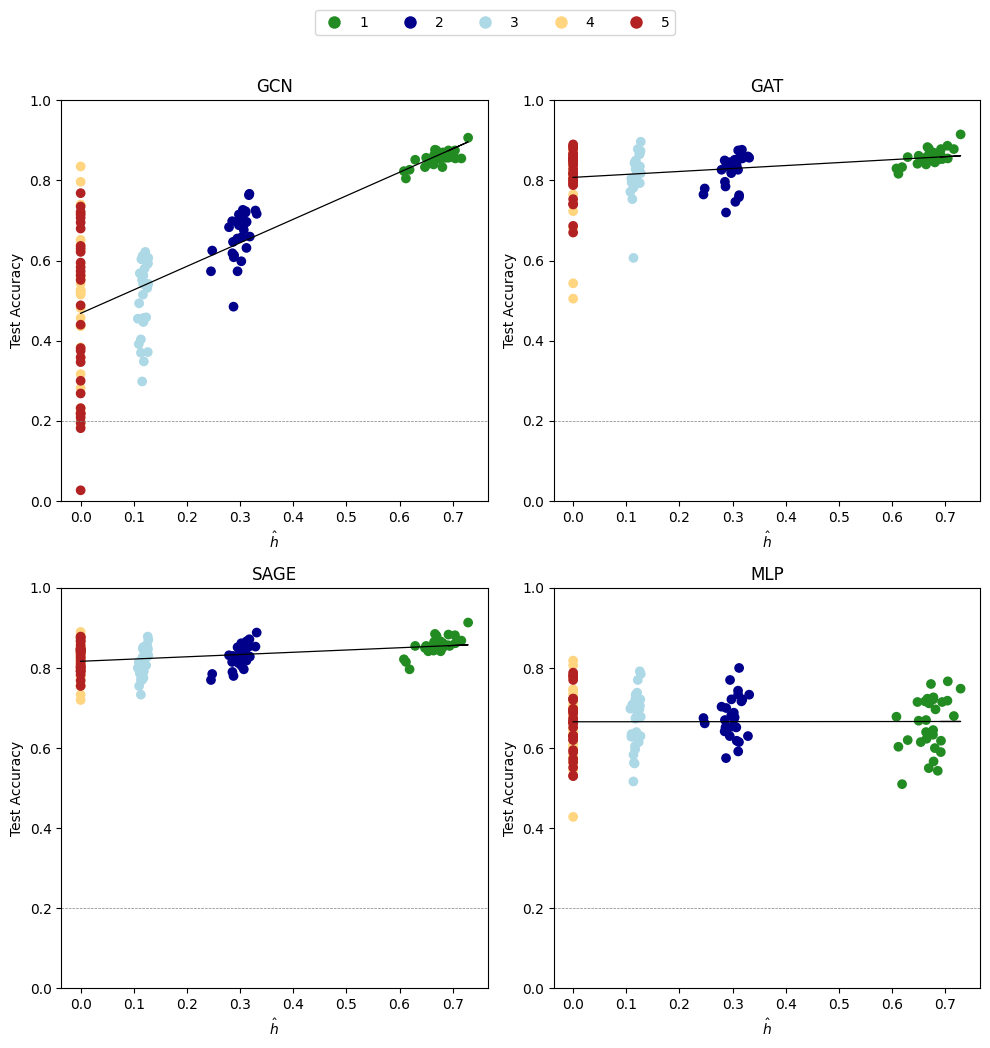

In [36]:
def plot_scatter_relation(X, y, colors, xlab):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    model_names = ["GCN", "GAT", "SAGE", "MLP"]

    color_labels = np.arange(1, len(colors) + 1)

    for i, ax in enumerate(axs.flatten()):

        repeated_colors = np.repeat(colors, 30)
        sc = ax.scatter(X, y[i, :, :].flatten(), color=repeated_colors)
        
        coef = np.polyfit(X, y[i, :, :].flatten(), 1)  
        poly1d_fn = np.poly1d(coef)
        print(model_names[i], "=", round(coef[0],3))
        ax.plot(X, poly1d_fn(X), '-', color='black', linewidth=.9)  
        ax.axhline(.2, linestyle="--", color="grey", linewidth=.5)

        ax.set_title(model_names[i])
        ax.set_xlabel(xlab)  
        ax.set_ylim((0,1))
        ax.set_ylabel('Test Accuracy')  


    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                           markerfacecolor=color, markersize=10) 
               for label, color in zip(color_labels, colors)]
    
    fig.legend(handles=handles, loc='upper center', ncol=len(color_labels), bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust layout to make room for the legend
    plt.show()

#plot_scatter_relation(x1, Y, colors = ["forestgreen", "darkblue", "lightblue",  "#FF8C00", "#FFD580", "firebrick"], xlab = r"$\hat{h}$")
plot_scatter_relation(x1, Y, colors = ["forestgreen", "darkblue", "lightblue","#FFD580", "firebrick"], xlab = r"$\hat{h}$")

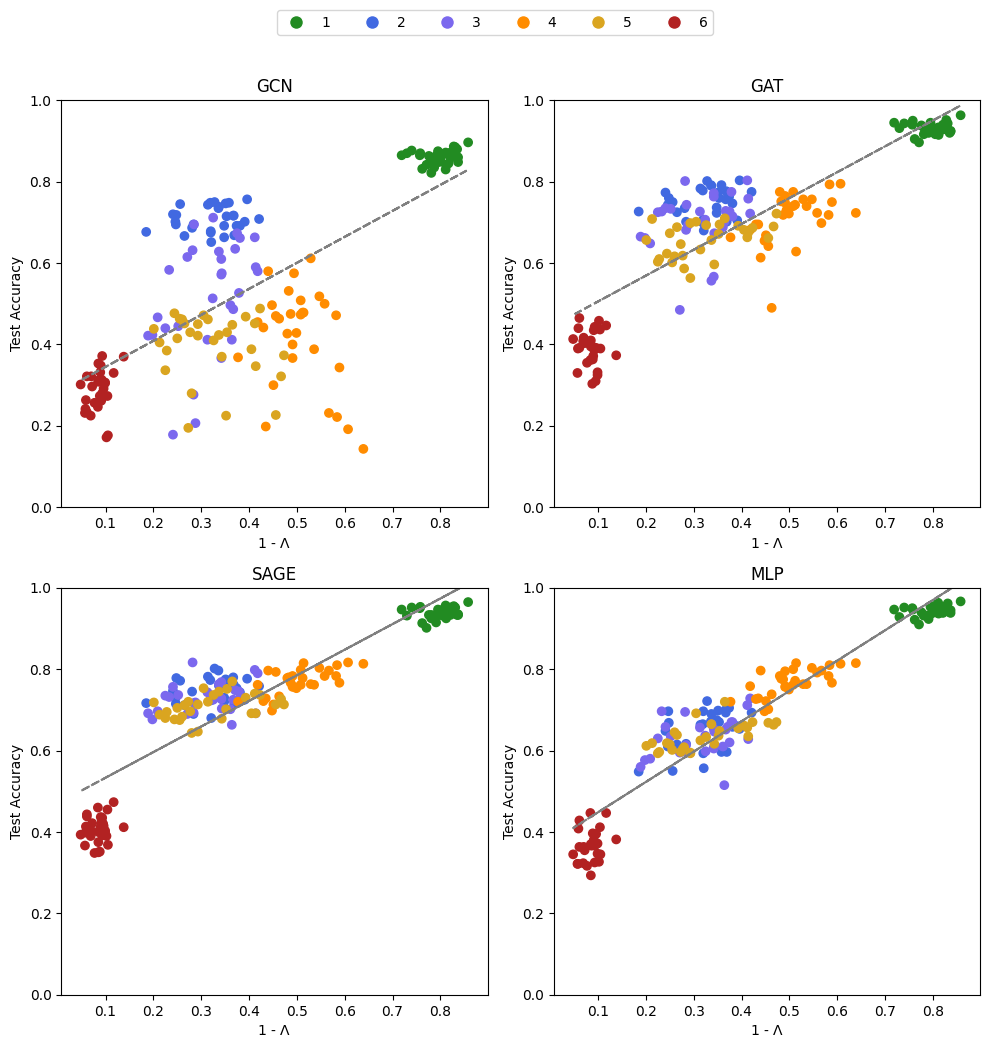

In [24]:
plot_scatter_relation(x2, Y, colors, r"1 - $\Lambda$")
